# M2 | Exploration Notebook

In this notebook, you will do a first exploration of the data set that you will use for your project. One part of this exploration is guided, i.e. we will ask you to solve specific questions (task 1-3). The other part is open, i.e. we will ask you to come up with your own exploration ideas (task 4). 

Please upload your solved notebook to Moodle (under Milestone 2 Submission)adding your SCIPER number in title, example: m2-lernnavi-456392.ipynb


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.


For the guided part of the exploration we will focus on the three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

### Users
* user_id: unique identifier of user in database.
* gender: only three values: M male, F female or missing (star). 
* canton: swiss canton.
* class_level: school year in swiss system.
* study: boolean variable. True if the student participated in the study.
* class_id: identifier of student’s class (only for the students in the experiment)


### Events
* event_id: unique identifier of event in database.
* user_id: user who peformed the event.
* event_date: timestamp of event.
* category: classification of action (task, general, statistics, etc).
* action: type of action performed.
* event_type: whether the students viewed or clicked in the event.
* transaction_token: used to link to transactions table.
* tracking_data: optional content associated to this event (e.g., the new points mastered for a topic).
* session_id: session during which the event took place.
* topic_id: the topics represent the taxonomy of categories shown in the Deutsch and Math dashboard. See topics_translated table.
* session_closed: whether the session has been finished (1: finished; 0: not finished).
* session_type: whether the session is a learn or level check (1: learn; 2: level check).
* session_accepted: whether the user finally accepted the result of the session (1: accepted; 0: refused).

### Transactions
* transaction_id: unique identifier of transaction in database.
* transaction_token: used to link to events table.
* user_id: user who performed the transaction.
* document_id: document that was answered in transaction.
* document_version: version of document that was answered.
* evaluation: whether the user answered correctly or not. It is possible that it was only partially right. 
* input: answer the user gave.
* start_time: timestamp of when the user started answering.
* commit_time: timestamp of when the user submitted the answer.
* user_agent: the browser that the user used.
* solution: solution to question.
* type: type of question that was answered. 
* session_id: session during which the event took place.
* topic_id: the topics represent the taxonomy of categories shown in the Deutsch and Math dashboard. See topics_translated table.
* session_closed: whether the session has been finished (1: finished; 0: not finished).
* session_type: whether the session is a learn or level check (1: learn; 2: level check).
* session_accepted: whether the user finally accepted the result of the session (1: accepted; 0: refused).
* challenge: (boolean) whether the transaction was part of a challenge or not. Professors can create challenges containing different documents
* challenge_id: unique identifier of challenges. The same challenge can be done by multiple students. The pre-test and post-test in the study were designed like challenges.
* challenge_order: within the challenge, the order of the questions. The order matters because sometimes the questions were adapted depending on the student’s knowledge.
* challenge_name: name given to the challenges. 

## Useful Metadata Files
* [Data description](https://docs.google.com/document/d/1NPFNwi79JddrxZM-CpltH5nHro5btHRSNnYcAGj7Y0A/edit?usp=sharing)


In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = '../data' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

## Task 1: Simple Statistics

In this task you are asked to do a first coarse exploration of the data set, using simple statistics and visualizations.

#### a) How many distinct participants do we have in the data set?


In [2]:
print('Number of unique user_ids:', users['user_id'].nunique())

Number of unique user_ids: 30929


#### b) How many transactions were done per user? Please provide a visualization and discuss the distribution.

In [3]:
# Group the transaction_ids by the user_ids, which counts up all transactions per user
transactions_per_user = transactions.groupby(['user_id'])['transaction_id'].nunique()

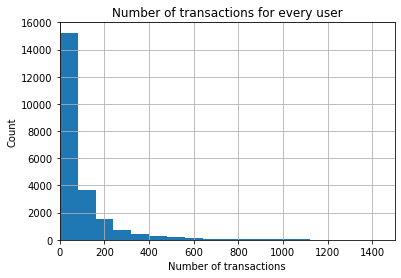

In [4]:
# We create a histogram, but we limit it to 1500 transactions in order for better visualization
transactions_per_user.hist(bins=200)
plt.xlim(0, 1500)
plt.ylabel('Count')
plt.xlabel('Number of transactions')
plt.title('Number of transactions for every user')
plt.show()

The distribution looks something like an exponential, which becomes visible when ignoring outliers. These are likely users that use the application a lot, with one person being at 15982 transactions; more than 8 times more than any other user. It could be interesting to investigate this user. The (what seems to be an exponential) decay in the histogram motivates my choice for the distribution, as well as then intuition that less and less people will have more time in the app (implying transactions) as time goes on.  

#### c) Which are the 10 most popular event actions? Please provide a visualization of the frequency of the top 10 event actions.

Hint: See actions in table events.

In [5]:
# This code groups the 10 largest actions
number_of_largest_cols = 10
num_events_per_action = events.groupby(['action'])['event_id'].nunique().nlargest(number_of_largest_cols)

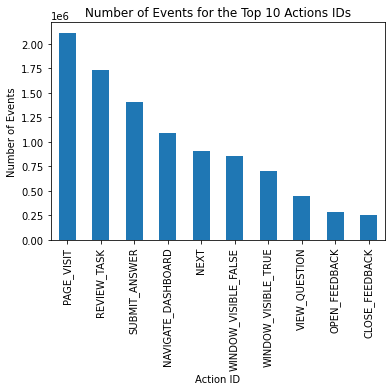

In [6]:
# We create a bar chart to display them
num_events_per_action.plot.bar()
plt.ylabel('Number of Events')
plt.xlabel('Action ID')
plt.title('Number of Events for the Top 10 Actions IDs')
plt.show()
plt.show()

The most common action seems to be PAGE_VISIT, which makes sense, as it is required for almost anything in the application. REVIEW_TASK seems to be second, most likely since there are multiple questions and a user has to click between them after doing a quick. This triggers this event each time. However, what is interesting is that SUBMIT_ANSWER is third highest. It seems like users are engaged with the application, and utilize the quiz instead of just skimming through. The dashboard (NAVIGATE_DASHBOARD) is also quite popular, since the users interact with different elements in the quiz. Students also seem to look at open-ended feedback a little more than closed-ended feedback, them being the top 9 and 10 most popular actions.

There is one weird thing, since the metadata mentions that SUBMIT_ANSWER should happen after VIEW_QUESTION and before NEXT. However, there seems to be less VIEW_QUESTION than SUBMIT_ANSWER, which is quite strange. I do not have a direct explanation for thism but it seems like something is going on.

## Task 2: Static Analysis

In this second task, you will do a univariate an multivariate exploration of some aggregated features.

#### a) Build a data frame containing one row per user:

``[user_id, gender, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered (hint: action event = submit answer)

- **num_events**: total number of events of the student (hint: in events table)  

- **percentage_correct**: number of correct answers/total number of answers (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers. 

- **num_reading**: total number of theory reading events  (hint: action event = go to theory)

In [7]:
# This is a function to count the number of occurrences of a string in a pandas Series
def cnt_column(series, col_name):
    return (series == col_name).sum()

# We first collect the gender and user_id
new_df_1 = users[['user_id', 'gender']].set_index('user_id')

# We then collect the number of questions by counting the number of "SUBMIT_ANSWER" actions per user
new_df_2 = events.groupby(['user_id'])['action'].apply(lambda x: cnt_column(x, 'SUBMIT_ANSWER')).reset_index(name='num_questions')
new_df_2 = new_df_2.set_index('user_id')

# Here, we count the number of events of each user
new_df_3 = events.groupby(['user_id'])['event_id'].nunique().reset_index('user_id')
new_df_3 = new_df_3.rename(columns={'event_id':'num_events'}).set_index('user_id')

# This dictionary assigns partial points for partially correctly answered questions
point_assignments = {
    'WRONG': 0,
    'PARTIAL': 0.5,
    'CORRECT': 1
}

# We now create a new temporary column that does this point mapping
transactions['point_evaluation'] = transactions['evaluation'].map(point_assignments)

# Now we create the average percentage of correct answers by averaging the number of points per user
# We decide to ignore NaNs in the computation by default
new_df_4 = transactions.groupby(['user_id'])['point_evaluation'].mean() * 100
new_df_4 = new_df_4.reset_index('user_id').rename(columns={'point_evaluation':'percentage_correct'}).set_index('user_id')

# Finally, we compute the number of readings by counting the amount of "GO_TO_THEORY" per user
new_df_5 = events.groupby(['user_id'])['action'].apply(lambda x: cnt_column(x, 'GO_TO_THEORY')).reset_index(name='num_reading')
new_df_5 = new_df_5.set_index('user_id')

# To create the full dataframe, we concatenate those components
new_df = pd.concat([new_df_1, new_df_3, new_df_2, new_df_4, new_df_5], axis=1, join='inner').reset_index()

In [8]:
# There might be NaNs, coming from entries that might not have existed when creating the dataframe above, but that's okay
print(new_df.head())

   user_id gender  num_events  num_questions  percentage_correct  num_reading
0   387604    NaN        5087            361           69.444444          677
1   387605    NaN        3604            239           57.352941           35
2   387608    NaN        2359            117           85.087719           58
3   387613    NaN         213              4          100.000000            7
4   387615   MALE         535             15           82.142857           18


b) Perform a univariate analysis (including descriptive statistics and visualizations) for the five features (gender, num_events, num_questions, percentage_correct, num_reading) of your dataframe. Please check the lecture slides regarding information on how to perform a univariate analysis for categorical and numerical features. Discuss your results: how are the features distributed? Are there any anomalities?

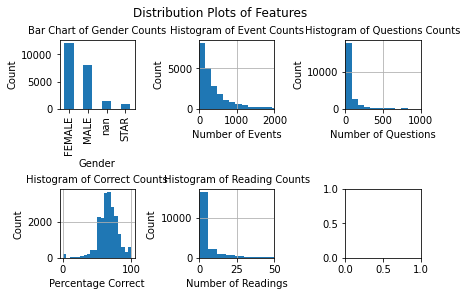

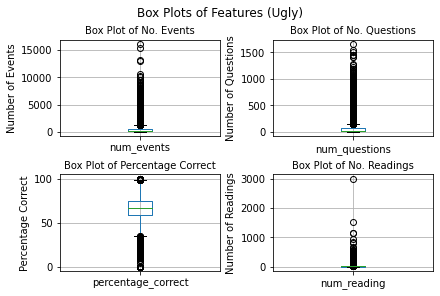

                  num_events  num_questions  percentage_correct   num_reading  \
count           22470.000000   22470.000000        21433.000000  22470.000000   
mean              498.138451      62.489631           65.595876      9.408901   
std               790.250740     108.525945           14.732039     39.260507   
min                 1.000000       0.000000            0.000000      0.000000   
25%               108.000000      10.000000           58.333333      0.000000   
50%               249.000000      28.000000           66.304348      1.000000   
75%               552.000000      68.000000           74.324324      6.000000   
max             16056.000000    1653.000000          100.000000   3000.000000   
count                    NaN            NaN                 NaN           NaN   
unique                   NaN            NaN                 NaN           NaN   
top                      NaN            NaN                 NaN           NaN   
freq                     NaN

In [9]:
# This script just creates some plots
indexed_df = new_df.set_index('user_id')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, constrained_layout=True)
fig.suptitle('Distribution Plots of Features')

indexed_df['gender'].value_counts(dropna=False).plot.bar(ax=ax1)
ax1.set_title('Bar Chart of Gender Counts', fontsize=10)
ax1.set_xlabel('Gender')
ax1.set_ylabel('Count')

# We limit the histogram to 2000, since the plot would get congested with outliers
indexed_df['num_events'].hist(ax=ax2, bins=100)
ax2.set_xlim(0, 2000)
ax2.set_title('Histogram of Event Counts', fontsize=10)
ax2.set_xlabel('Number of Events')
ax2.set_ylabel('Count')

# We limit the histogram to 1000, since the plot would get congested with outliers
indexed_df['num_questions'].hist(ax=ax3, bins=20)
ax3.set_xlim(0, 1000)
ax3.set_title('Histogram of Questions Counts', fontsize=10)
ax3.set_xlabel('Number of Questions')
ax3.set_ylabel('Count')

indexed_df['percentage_correct'].hist(ax=ax4, bins=20)
ax4.set_title('Histogram of Correct Counts', fontsize=10)
ax4.set_xlabel('Percentage Correct')
ax4.set_ylabel('Count')

# We limit the histogram to 50, since the plot would get congested with outliers
indexed_df['num_reading'].hist(ax=ax5, bins=500)
ax5.set_xlim(0, 50)
ax5.set_title('Histogram of Reading Counts', fontsize=10)
ax5.set_xlabel('Number of Readings')
ax5.set_ylabel('Count')

plt.show()

# We create some boxplots to show outliers and (kind of) get an idea of the distributions
# They are meant to be ugly, and just have to show information about outliers
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=True)
fig.suptitle('Box Plots of Features (Ugly)')

indexed_df.boxplot(column=['num_events'], ax=ax1)
ax1.set_title('Box Plot of No. Events', fontsize=10)
ax1.set_ylabel('Number of Events')

indexed_df.boxplot(column=['num_questions'], ax=ax2)
ax2.set_title('Box Plot of No. Questions', fontsize=10)
ax2.set_ylabel('Number of Questions')

indexed_df.boxplot(column=['percentage_correct'], ax=ax3)
ax3.set_title('Box Plot of Percentage Correct', fontsize=10)
ax3.set_ylabel('Percentage Correct')

indexed_df.boxplot(column=['num_reading'], ax=ax4)
ax4.set_title('Box Plot of No. Readings', fontsize=10)
ax4.set_ylabel('Number of Readings')

plt.show()

# Compute Descriptive Statistics
# Partially taken from tutorial 02

numerical = indexed_df.describe(include=['float64', 'int64'])
categorical = indexed_df.describe(include=['object'])
stats = pd.concat([numerical, categorical])
missing_counts = indexed_df.isnull().sum(axis = 0)
stats.loc['missing_values'] = missing_counts

print(stats)

Let's start with the gender of the users. There seem to be more users who registered as females than males. Furthermore, a small percentage of the users also identifies as neither. However, there are just as many users who do not report having any gender. There are no clear anomalies for this column. 

The second feature, which is the number of events for each user, seems to be exponentially distributed from the histogram. Furthermore, from the description and boxplot of the feature, there do appear to be some outliers. The largest, as previously mentioned, having over 16000 events. It would be interesting to investigate this user.

The third feature, which is the number of questions for each user, also seems to be exponentially distributed. From the boxplot and description of this feature, there are also some outliers, but these are not of the same magnitude as the one of the number of events. These are likely just very active users, but this group could also be interesting to investigate.

The fourth feature, which is the overall percentage correct, could represent a normal distribution, with the values truncated between 0 and 100. This truncation explains the small anomalies (spikes) at 0 and 100, because the worst and the best users are given the same score at those points. There are also some missing values, which indicates that some users may not have have attempted any questions.

The last feature is the number of readings per user. This again seems to follow an exponential distribution, with some users that read a lot. However, it is also clear that one user had 3000 readings, which is an incredible amount more than the median of 75th percentile of 6! There are also a few more users that have around 1500 to 2000 readings, which is also significantly more than the majority of users.

c) Come up with two additional features on your own and add them to the dataframe. Please provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.

In [10]:
transactions['minutes_answer_time'] = pd.to_datetime(transactions['commit_time']) - pd.to_datetime(transactions['start_time'])
transactions['minutes_answer_time'] = transactions['minutes_answer_time'].dt.total_seconds() / 60

answer_time_feature = transactions.groupby(['user_id'])['minutes_answer_time'].mean()

percentage_sessions_finished = transactions.groupby(['user_id'])['session_closed'].mean() * 100

own_features_df = new_df.set_index('user_id')
own_features_df = pd.concat([own_features_df, answer_time_feature, percentage_sessions_finished], axis=1, join='inner').reset_index()

I have added the following two features to the dataframe:

- The average amount of minutes it takes to answer a question for each user

This feature seems interesting to look into, because it gives rise to different types of users. For example, maybe users that on average spend more time on questions have a higher percentage of answers correct.

- The percentage of closed sessions for each user

This will give rise to the number of sessions that have been completed by the user. It could be interesting to see whether users usually finish sessions, or maybe look at correlations between this feature and the behaviour on the application.

d) Perform a univariate analysis of your features (including descriptive statistics and visualization). What can you observe? Do the results confirm your hypotheses?

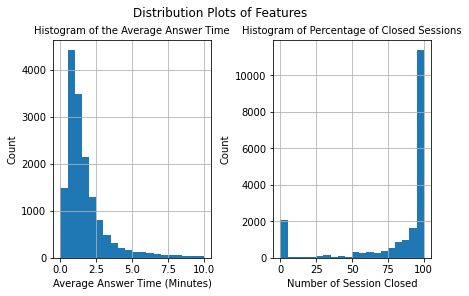

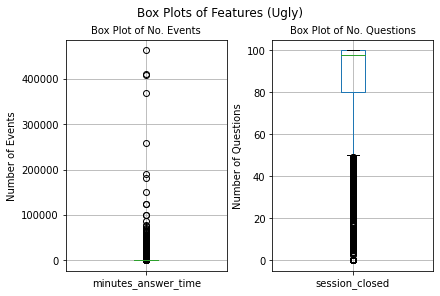

                minutes_answer_time  session_closed
count                  21574.000000    19565.000000
mean                     615.677277       81.213916
std                     7091.111484       32.020461
min                        0.017889        0.000000
25%                        0.958007       80.000000
50%                        1.809752       97.959184
75%                       21.369162      100.000000
max                   462673.885367      100.000000
missing_values           896.000000     2905.000000


In [11]:
indexed_own_features_df = own_features_df.set_index('user_id')

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
fig.suptitle('Distribution Plots of Features')

# For plotting, we limit up to 10 minutes on average and create a bin for each 30 second interval
indexed_own_features_df[indexed_own_features_df['minutes_answer_time'] < 10]['minutes_answer_time'].hist(ax=ax1, bins=20)
ax1.set_title('Histogram of the Average Answer Time', fontsize=10)
ax1.set_xlabel('Average Answer Time (Minutes)')
ax1.set_ylabel('Count')

indexed_own_features_df['session_closed'].hist(ax=ax2, bins=20)
ax2.set_title('Histogram of Percentage of Closed Sessions', fontsize=10)
ax2.set_xlabel('Number of Session Closed')
ax2.set_ylabel('Count')

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
fig.suptitle('Box Plots of Features (Ugly)')

indexed_own_features_df.boxplot(column=['minutes_answer_time'], ax=ax1)
ax1.set_title('Box Plot of No. Events', fontsize=10)
ax1.set_ylabel('Number of Events')

indexed_own_features_df.boxplot(column=['session_closed'], ax=ax2)
ax2.set_title('Box Plot of No. Questions', fontsize=10)
ax2.set_ylabel('Number of Questions')

plt.show()

# Compute Descriptive Statistics
# Partially taken from tutorial 02

stats = indexed_own_features_df[['minutes_answer_time', 'session_closed']].describe(include=['float64', 'int64'])
missing_counts = indexed_own_features_df[['minutes_answer_time', 'session_closed']].isnull().sum(axis = 0)
stats.loc['missing_values'] = missing_counts

print(stats)

The histogram of the feature describing the average answer time for each user is quite interesting. When looking at bins that each represent one minute, the histogram again looks exponential. However, when sizing down on the bin sizes, for example having it be 30 seconds per bin, there is a bit of a structure that could represent something like a log-normal distribution. For example, few users have an average answer time of under 30 seconds. The median average answer time is about 1.8 minutes. However, there are some large anomalies in the data, as can be seem from the boxplot and the descriptive statistics. The maximum value is about 462673 minutes, which should definitely be investigated.

For the percentage of closed sessions, the distribution seems to represent some mirrored (in the x-axis) truncated exponential distribution. The exponential distribution could be obtained by changing the feature to the percentage of open sessions. The values between constrainted to between 0 and 100% explains why there are many at 0 From the boxplot and description, there do not seem to be many outliers, but just these users that don't have any closed session. There are also quite some missing values, indicating quite some NaNs.

e) Perform a multivariate analysis for two pairs of features of your choice. Please provide a metric and a visualization for both pairs. Please discuss: why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?

Correlation: 0.039391147448481816


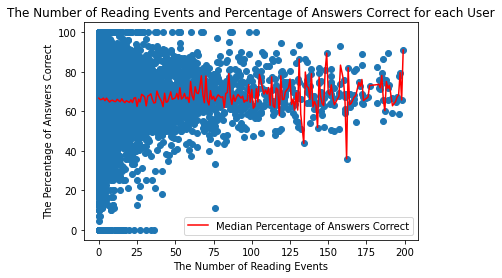

In [12]:
filtered_df = own_features_df[own_features_df['num_reading'] < 200]

print('Correlation:', filtered_df['num_reading'].corr(filtered_df['percentage_correct']))

group = filtered_df.groupby('num_reading').agg({'percentage_correct': 'median'})

plt.scatter(filtered_df['num_reading'], filtered_df['percentage_correct'])
plt.plot(group.index, group['percentage_correct'], color='red', label='Median Percentage of Answers Correct')
plt.legend()
plt.title('The Number of Reading Events and Percentage of Answers Correct for each User')
plt.xlabel('The Number of Reading Events')
plt.ylabel('The Percentage of Answers Correct')
plt.show()

I chose to create a multivariate analysis for the variables "num_reading" and "percentage_correct", in order to see if there is some relationship between them. I hoped to see that users with a higher number of readings have a higher average percentage of correct answers. I first created a scatterplot, which had too many datapoints to be interpretable. From the scatterplot alone, it could seem that there is a smaller amount of people with a lower score. However, since there are likely many more users that read fewer events, this can't be made out from the plot.  I only included up to 200 reading numbers to make the plot more readable, and since that is well beyond the 75th percentile.

For this reason, I compute the correlation, which is incredibly low, indicating little to no linear relationship between the variables. Then, I plotted the median of the percentage of correct answers for each number of readings. While there is much more certainty for smaller values (since there are many datapoints), there does not seem to be an increase in the median percentage of correct answers for a larger number of readings. However, it is important to note that the variance for more number of readings is also much larger. Hence, the results do not seem to support my hypothesis.

# Task 3: Time-Series Analysis

In the last task, you will perform a time-series analysis.


#### a) Build a data frame containing one row per user per week:

``[user_id, week, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered **per week**(hint: action event = submit answer).

- **num_events**: total number of events of the student per week.

- **percentage_correct**: number of correct answers/total number of answers  **per week** (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers.

- **num_reading**: total number of theory reading events **per week** (hint: action event = go to theory).

Where week 0 is the first week the specific user solved a task in the platform, i.e., the user's earliest entry in the transactions table.

Hint: You may extract the week of the year (dt.week) from the timestamps.

Hint 2: Be mindful that week 1 in 2022 is a different week from week 1 in 2023.

You can limit the number of weeks to 10, i.e. for each user we just look at the first 10 weeks of data.
You may change and justify your choice for the number of weeks.

In [13]:
def cnt_column(series, col_name):
    return (series == col_name).sum()

# Create the week columns in both dataframes
transactions['start_time'] = pd.to_datetime(transactions['start_time'])
events['event_date'] = pd.to_datetime(events['event_date'])

# Find the first transaction for each user
first_transaction_times = transactions.groupby('user_id')['start_time'].min()

# Then add this first transaction as a column to both dataframes
# Afterwards, we compute the number of weeks from a certain transaction using the difference between them 
transaction_with_week = transactions.merge(first_transaction_times, on='user_id', suffixes=['', '_min'])
transaction_with_week['week'] = (transaction_with_week['start_time'] - transaction_with_week['start_time_min']).dt.days // 7

events_with_week = events.merge(first_transaction_times, on='user_id', suffixes=['', '_min'])
events_with_week['week'] = (events_with_week['event_date'] - events_with_week['start_time']).dt.days // 7

# Now we create the statistics

WEEK_LIMIT = 10
transaction_with_week = transaction_with_week[(0 <= transaction_with_week['week']) & (transaction_with_week['week'] < WEEK_LIMIT)]
events_with_week = events_with_week[(0 <= events_with_week['week']) & (events_with_week['week'] < WEEK_LIMIT)]

ts_df_1 = events_with_week.groupby(['user_id', 'week'])['action'].apply(lambda x: cnt_column(x, 'SUBMIT_ANSWER'))
ts_df_1 = ts_df_1.rename('num_questions')

ts_df_2 = events_with_week.groupby(['user_id', 'week'])['event_id'].nunique()

point_assignments = {
    'WRONG': 0,
    'PARTIAL': 0.5,
    'CORRECT': 1
}

transaction_with_week['point_evaluation'] = transaction_with_week['evaluation'].map(point_assignments)

# We decide to ignore NaNs in the computation by default
ts_df_3 = transaction_with_week.groupby(['user_id', 'week'])['point_evaluation'].mean() * 100

ts_df_4 = events_with_week.groupby(['user_id', 'week'])['action'].apply(lambda x: cnt_column(x, 'GO_TO_THEORY'))

ts_df = pd.concat([ts_df_1, ts_df_2, ts_df_3, ts_df_4], axis=1).reset_index()
ts_df = ts_df.rename(columns={
    'event_id': 'num_events', 
    'point_evaluation': 'percentage_correct',
    'action': 'num_reading'
})

#### b) Select two features and analyze their behavior over time. Please provide a hypothesis and visualization for both features. For ideas on how to perform a time series exploration, please check the lecture slides and notebook. Discuss your results: what do you observe? Do the results confirm your hypotheses?

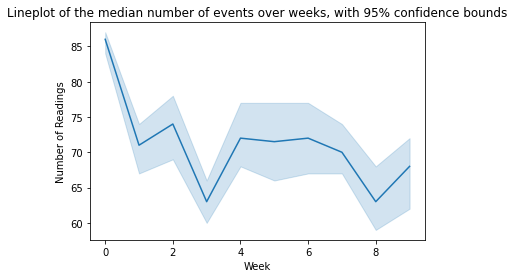

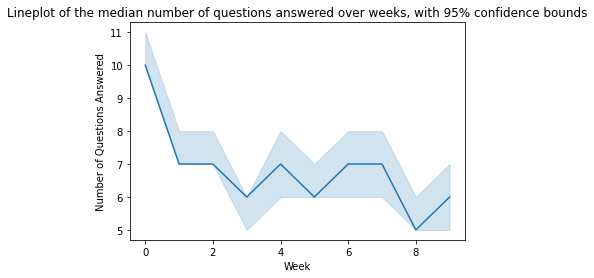

In [14]:
import seaborn as sns

sns.lineplot(x="week", y="num_events", data=ts_df, estimator=np.median)
plt.title('Lineplot of the median number of events over weeks, with 95% confidence bounds')
plt.xlabel('Week')
plt.ylabel('Number of Readings')
plt.show()

sns.lineplot(x="week", y="num_questions", data=ts_df, estimator=np.median)
plt.title('Lineplot of the median number of questions answered over weeks, with 95% confidence bounds')
plt.xlabel('Week')
plt.ylabel('Number of Questions Answered')
plt.show()

I selected the features "num_events" and "num_questions" to gain insights into how users utilize the application over the first 10 weeks that they use it. I have three hypotheses:

1. The median number of readings will decline as the number of weeks increase
2. The median number of questions answered will decline as the number of weeks increase
3. The trends of the number of readings and the number of questions will be quite similar over the weeks

The first and second hypothesis aim to test whether users will read fewer articles and answer fewer questions peer week as the period of them using the application increases. Finally, the third hypothesis aims to see whether the behaviour of the users for answering questions will differ from the behaviour of readings.

It is important to note that I used the median as an estimator in these plots, because it is more robust to outliers like the ones we observed previously. From the first and second plot, a gradual decline in the median number of readings, and a gradual decline in the median number of answered questions is observed. It seems that users answer the most questions and read the most articles in the first week. Afterwards, they seem to use it less but kind of stabilize (with emphasis on kind of). This confirms my first and second hypothesis. Regarding the third hypothesis, the trends between the two features seem to be quite similar, but with more absolute variability in the number of readings. This might indicate that users utilize both features less, instead of preferring one to the other.  

# Task 4: Creative extension 

Please provide **one** new hypothesis you would like to explore with the data and provide a visualization for it. Discuss your results: what do you observe? Do the results confirm your hypotheses?



Correlation: -0.01804780180874369


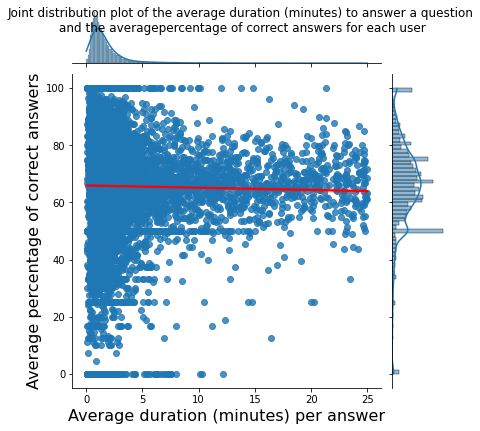

In [15]:
filtered_df = own_features_df[own_features_df['minutes_answer_time'] < 25]

print('Correlation:', filtered_df['minutes_answer_time'].corr(filtered_df['percentage_correct']))

p = sns.jointplot(x="minutes_answer_time", y="percentage_correct", data=filtered_df, kind="reg", line_kws={"color": "red"})
p.fig.suptitle('Joint distribution plot of the average duration (minutes) to answer a question\n and the average' 
          + 'percentage of correct answers for each user')
p.set_axis_labels('Average duration (minutes) per answer', 'Average percentage of correct answers', fontsize=16)
plt.show()

I added a feature which measures the average time to answer a question for each user. My hypothesis is now that a larger time it takes to answer questions results in a higher average percentage of correct answers.

I first created a joint distribution plot of the two variables. I limited the average minutes per answer to 25, since this already covers the majority of the users. Then, I fitted a regression line through the data, and with that, computed the correlation between the variables. Like in task 2d, there are many more users with a smaller average duration per answer. This makes the plot seem like there might be a trend, but in reality, the regression model and correlation indicate the opposite. Hence, again, the analysis does not seem to support my hypothesis.

*I just realized that the plot above probably isn't what was meant by this question, so I will provide an additional hypothesis from the data, independent of the previous analysis:*

Number of users that participated in at least one challenge: 10294
Number of users that did not participate in any challenge: 12176


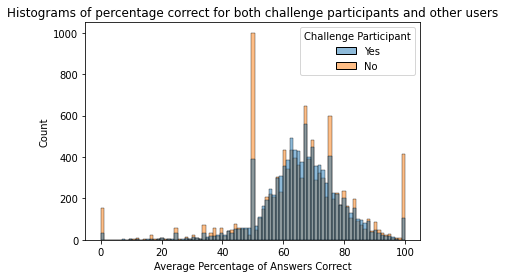

Descriptive statistics challengers: count    10198.000000
mean        66.059484
std         12.791243
min          0.000000
25%         59.375000
50%         66.399137
75%         73.809524
max        100.000000
Name: percentage_correct, dtype: float64

Descriptive statistics other users: count    11235.000000
mean        65.175060
std         16.283927
min          0.000000
25%         57.142857
50%         66.176471
75%         75.000000
max        100.000000
Name: percentage_correct, dtype: float64


In [59]:
# Merge events and transactions on transaction_token
merged_data = pd.merge(events, transactions, on='transaction_token')

# Get the users that participated in challenges
challenge_participants = merged_data[merged_data['challenge'] == True]['user_id_x'].unique()

print('Number of users that participated in at least one challenge:', len(challenge_participants))
print('Number of users that did not participate in any challenge:', len(new_df['user_id'].unique()) - len(challenge_participants))

# Create a new column for whether a person participated in a challenge
new_df['Challenge Participant'] = 'No'
new_df.loc[new_df['user_id'].isin(challenge_participants), 'Challenge Participant'] = 'Yes'

# Create the plot
sns.histplot(data=new_df, x="percentage_correct", hue="Challenge Participant")
plt.title('Histograms of percentage correct for both challenge participants and other users')
plt.xlabel('Average Percentage of Answers Correct')
plt.show()

# Distribution median
print('Descriptive statistics challengers:', new_df[new_df['Challenge Participant'] == 'Yes']['percentage_correct'].describe())
print()
print('Descriptive statistics other users:', new_df[new_df['Challenge Participant'] == 'No']['percentage_correct'].describe())

I created a new feature encodes whether a user has participated in a challenge. The hypothesis is that users who have previously participated in at least one challenge obtain a better average percentage of correct answers than other users. 

In order to analyze this hypothesis, I created a plot that has histogram for both the challenge participants and the users who have not participated in a challenge. From the histogram, it seems that both distributions are quite alike. In order to confirm this claim, I computed some descriptive statistics of both distributions. It seems that the distribution are almost identical up to a certain small difference in quartiles and mean. Furthermore, while the standard deviation has the largest difference between both distributions, it is still not much in the range of values.

In conclusion, the evidence we have collected seems to reject the hypothesis that I proposed. However, it could be interesting to look at users that have participated in multiple (e.g. at least 10) challenges, since the effect of the challenges might not be immediate. 